# Evaluation for MapGen models

In [1]:
import matplotlib
#matplotlib.use('Agg') # necessary for linux kernal
%matplotlib inline
import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras import models
from keras.models import load_model
from keras.layers import Input
from keras.models import Model

from data_helper import readImg

def update_gan_generator_to_any_size(old_model):
    # Remove the top layer and add input with no limit
    old_model.layers.pop(0) 
    newInput = Input(shape=(None, None, 1)) # New image input
    newOutputs = old_model(newInput)
    newModel = Model(newInput, newOutputs)

    return newModel

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
if 0:
    #scale = 25
    #modelPath = '../tmp_results/predictions/2018-07-20 07-53-50_25/'
    #out_evaluation = r"../tmp_results/Evaluations/Unet_25k/"
    
    #scale = 15
    #modelPath = '../tmp_results/predictions/2018-07-19 13-13-22_15/'
    #out_evaluation = r"../tmp_results/Evaluations/Unet_15k/"
    
    scale = 10
    modelPath = '../tmp_results/predictions/2018-07-19 15-14-38_10/'
    out_evaluation = r"../tmp_results/Evaluations/Unet_10k/"

    modelname = "weights.hdf5"
    saved_model = models.load_model(modelPath + modelname)

In [3]:
if 0:
    scale = 15

    #modelPath = '../tmp_results/predictions/2019-01-17 12-16-50_15/'
    #out_evaluation = r"../tmp_results/Evaluations/GAN_15k/"
    #epoch = max(epochs)

    #modelPath = '../tmp_results/predictions/2019-01-17 16-22-56_15/' # MSE MAE 1:1000, not better than the case with 1:100
    #out_evaluation = r"../tmp_results/Evaluations/GAN_15k_1000/"
    #epoch = max(epochs)
    
    epoch = 22
    modelPath = '../tmp_results/predictions/2019-01-22 18-19-09_15/' # MSE MAE 1:1000, not better than the case with 1:100
    out_evaluation = r"../tmp_results/Evaluations/GAN_15k_clip/"

In [4]:
if 0:
    scale = 10
    
    #modelPath = '../tmp_results/predictions/2019-01-17 20-29-09_10/'
    #out_evaluation = r"../tmp_results/Evaluations/GAN_10k/",
    #epoch = max(epochs)

In [5]:
if 1:
    scale = 25
    
    #epoch = 3
    #modelPath = '../tmp_results/predictions/2019-01-18 11-13-51_25/'
    #out_evaluation = r"../tmp_results/Evaluations/GAN_25k/"
    
    #epoch = 5
    #modelPath = '../tmp_results/predictions/2019-01-18 14-03-51_25/' # Best 25k
    #out_evaluation = r"../tmp_results/Evaluations/GAN_25k/"
    
    #epoch = 11
    #modelPath = '../tmp_results/predictions/2019-01-23 13-20-19_25/' # Best 25k
    #out_evaluation = r"../tmp_results/Evaluations/GAN_25k_clip/"
    
    epoch = 13
    modelPath = '../tmp_results/predictions/2019-01-23 16-48-27_25/' # Best 25k
    out_evaluation = r"../tmp_results/Evaluations/GAN_25k_clip/" 

In [6]:
    modelnames = [modelname for modelname in os.listdir(modelPath) if '.h5' in modelname]
    epochs = [int(modelname.split('epoch')[1].split('.')[0]) for modelname in modelnames]
    
    modelname = "model_epoch" +str(epoch)+ ".h5"
    print(modelPath + modelname, 'loaded')
    
    saved_model = load_model(modelPath + modelname)
    saved_model = update_gan_generator_to_any_size(saved_model)

../tmp_results/predictions/2019-01-23 16-48-27_25/model_epoch13.h5 loaded


/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [7]:
def IoUcheck(img_input, img_output):
    # Pixelwise IoU score
    logic_and = np.sum(np.logical_and(img_output, img_input))
    logic_or = np.sum(np.logical_or(img_output, img_input))
    return logic_and/logic_or

def rescaleImg(image_arr):
    # Rescale the image to 8 x n
    if image_arr.shape[0] % 8 != 0:
        n = image_arr.shape[0] % 8
        new_x = image_arr.shape[0] - n
    else:
        new_x = image_arr.shape[0]

    if image_arr.shape[1] % 8 != 0:
        n = image_arr.shape[1] % 8
        new_y = image_arr.shape[1] - n
    else:
        new_y = image_arr.shape[1]

    image_arr = image_arr[:new_x, :new_y]

    return image_arr

def save_prediction(img, out_path, out_filename, subfix):
    fig = plt.figure(figsize=(img.shape[1] / 1000, img.shape[0] / 1000), dpi=100, frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    plt.imshow(img, cmap='gray')
    fig.savefig(out_path + out_filename + subfix, dpi=1000)
    
def evaluate(image_arrA, image_arrB):
    
    target_names = ['0', '1']
    
    y_true = image_arrB.flatten().astype(bool) 
    y_pred = image_arrA.flatten().astype(bool)
        
    Accuracy = accuracy_score(y_true, y_pred)
    IntOverUnion = IoUcheck(y_true, y_pred)
    conf = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=target_names)
        
    print('Acc:', Accuracy)
    print('Error:', 1 - Accuracy)
    print('IoU:', IntOverUnion)
    print(conf)
    #print(report)

    return Accuracy, IntOverUnion, conf, report

def model_predict(newModel, input_image, num_runs):
    # Predict with model for n times
    m,n = input_image.shape
    for i in range(num_runs):
        input_image = np.reshape(input_image, (1, m, n, 1))
        input_image = newModel.predict([input_image])
        input_image = np.reshape(input_image,(m, n)) > 0.5
    return input_image

def predict_eval(SavedModel, img_range, testPath, fn_input, fn_target, out_path, scale, nr = 1):

    image_arr = readImg(testPath + fn_input)
    image_tar = readImg(testPath + fn_target)
    
    if len(img_range) == 4: # If range was set
        xmin, xmax, ymin, ymax = img_range
        image_arr = image_arr[xmin:xmax, ymin:ymax]
        image_tar = image_tar[xmin:xmax, ymin:ymax]
    
    print("- " + str(scale) +"k", 'Example: ', image_arr.shape)
    evals_orig = evaluate(image_arr, image_tar)
    
    image_arr = rescaleImg(image_arr)
    image_tar = rescaleImg(image_tar)
    
    print("+ " + str(scale) +"k", 'Prediction: ', image_arr.shape)
    pred = model_predict(SavedModel, image_arr, num_runs = nr)
    evals_pred = evaluate(pred > 0.5, image_tar)
    
    save_prediction(pred, out_path, fn_input[:-4], '_' + str(scale) + '_' + str(nr) + '_out.png')
    return [evals_orig, evals_pred]

def predict_only(SavedModel, img_range, testPath, fn_input, out_path, scale, nr = 1):

    image_arr = readImg(testPath + fn_input)
    
    if len(img_range) == 4: # If range was set
        xmin, xmax, ymin, ymax = img_range
        image_arr = image_arr[xmin:xmax, ymin:ymax]
    
    image_arr = rescaleImg(image_arr)
    
    print("+ " + str(scale) +"k", 'Prediction: ', image_arr.shape)
    pred = model_predict(SavedModel, image_arr, num_runs = nr)
    
    save_prediction(pred > 0.5, out_path, fn_input[:-4], '_' + str(scale) + '_' + str(nr) + '_out.png')

## For all scales

- 25k Example:  (2400, 2400)
Acc: 0.9748284722222222
Error: 0.025171527777777758
IoU: 0.8775750421556682
[[4575699   66991]
 [  77997 1039313]]
+ 25k Prediction:  (2400, 2400)
Acc: 0.9856715277777778
Error: 0.014328472222222222
IoU: 0.9286732227289501
[[4602903   39787]
 [  42745 1074565]]


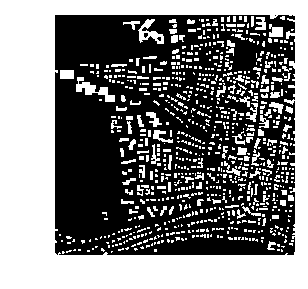

In [8]:
tester_path = r"../tmp_data/Data/Testing_large/4270/"

all_records = []
records = predict_eval(saved_model, [0,2400,500,2900], tester_path, r"geb_clip_4270.png", r"geb"+str(scale)+"_clip_4270.png", out_evaluation, scale, nr = 1)
all_records.extend(records)

- 25k Example:  (2400, 2400)
Acc: 0.9748284722222222
Error: 0.025171527777777758
IoU: 0.8775750421556682
[[4575699   66991]
 [  77997 1039313]]
+ 25k Prediction:  (2400, 2400)
Acc: 0.9854029513888889
Error: 0.014597048611111108
IoU: 0.9274832203766984
[[4600558   42132]
 [  41947 1075363]]


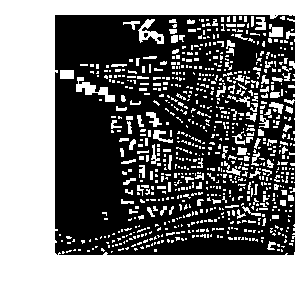

In [9]:
records = predict_eval(saved_model, [0,2400,500,2900], tester_path, r"geb_clip_4270.png", r"geb"+str(scale)+"_clip_4270.png", out_evaluation, scale, nr = 2)
all_records.extend(records)

In [10]:
all_records

[(0.9748284722222222, 0.8775750421556682, array([[4575699,   66991],
         [  77997, 1039313]]), '             precision    recall  f1-score   support\n\n          0       0.98      0.99      0.98   4642690\n          1       0.94      0.93      0.93   1117310\n\navg / total       0.97      0.97      0.97   5760000\n'),
 (0.9856715277777778, 0.9286732227289501, array([[4602903,   39787],
         [  42745, 1074565]]), '             precision    recall  f1-score   support\n\n          0       0.99      0.99      0.99   4642690\n          1       0.96      0.96      0.96   1117310\n\navg / total       0.99      0.99      0.99   5760000\n'),
 (0.9748284722222222, 0.8775750421556682, array([[4575699,   66991],
         [  77997, 1039313]]), '             precision    recall  f1-score   support\n\n          0       0.98      0.99      0.98   4642690\n          1       0.94      0.93      0.93   1117310\n\navg / total       0.97      0.97      0.97   5760000\n'),
 (0.9854029513888889, 0.9

In [11]:
_records = [(acc * 100, (1-acc) * 100, iou * 100) for acc, iou, conf, report in all_records]

import pandas as pd
df = pd.DataFrame(np.transpose(_records))
df.columns = ["Input vs Target (4270)", "Prediction vs Target (4270 - 1)", 
              "Input vs Target (4270_)", "Prediction vs Target (4270 - 10)"]

#df.columns = ["Input vs Target (4270)", "Prediction vs Target (4270 - 1)"]

df = df.rename({0: "Accuracy", 1: 'Error', 2: 'IoU'})
df.index.name = 'Metrics'

df[["Input vs Target (4270)", "Prediction vs Target (4270 - 1)", "Prediction vs Target (4270 - 10)"]]
#df[["Input vs Target (4270)", "Prediction vs Target (4270 - 1)"]]

,Input vs Target (4270),Prediction vs Target (4270 - 1),Prediction vs Target (4270 - 10)
Metrics,,,
Accuracy,97.482847,98.567153,98.540295
Error,2.517153,1.432847,1.459705
IoU,87.757504,92.867322,92.748322


+ 25k Prediction:  (168, 824)
+ 25k Prediction:  (120, 680)
+ 25k Prediction:  (88, 488)
+ 25k Prediction:  (56, 264)


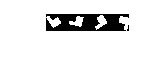

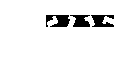

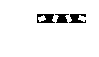

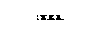

In [12]:
tester_path = r"../tmp_data/Data/Testing/"

predict_only(saved_model, [], tester_path, r"h1.tif", out_evaluation, scale, nr = 1)
predict_only(saved_model, [], tester_path, r"h2.tif", out_evaluation, scale, nr = 1)
predict_only(saved_model, [], tester_path, r"h3.tif", out_evaluation, scale, nr = 1)
predict_only(saved_model, [], tester_path, r"h4.tif", out_evaluation, scale, nr = 1)

## Only for 15k

In [13]:
if scale == 15:
    tester_path = r"../tmp_data/Data/Testing/"

    all_records = []

    records = predict_eval(saved_model, [], tester_path, r"FTest1_input_inv.png", r"FTest1_output_inv.png", out_evaluation, scale, nr = 1)
    all_records.extend(records)
    records = predict_eval(saved_model, [], tester_path, r"FTest2_input_inv.png", r"FTest2_output_inv.png", out_evaluation, scale, nr = 1)
    all_records.extend(records)
    records = predict_eval(saved_model, [], tester_path, r"FTest1_input_inv.png", r"FTest1_output_inv.png", out_evaluation, scale, nr = 10)
    all_records.extend(records)
    records = predict_eval(saved_model, [], tester_path, r"FTest2_input_inv.png", r"FTest2_output_inv.png", out_evaluation, scale, nr = 10)
    all_records.extend(records)

    _records = [(acc * 100, (1-acc) * 100, iou * 100) for acc, iou, conf, report in all_records]

    import pandas as pd
    df = pd.DataFrame(np.transpose(_records))
    df.columns = ["Input vs Target (Test1)", "Prediction vs Target (Test1 - 1)", 
                  "Input vs Target (Test2)", "Prediction vs Target (Test2 - 1)",
                  "Input vs Target (Test1)_", "Prediction vs Target (Test1 - 10)", 
                  "Input vs Target (Test2)_", "Prediction vs Target (Test2 - 10)"]

    df = df.rename({0: "Accuracy", 1: 'Error', 2: 'IoU'})
    df.index.name = 'Metrics'

In [14]:
    df[["Input vs Target (Test1)", "Prediction vs Target (Test1 - 1)", "Prediction vs Target (Test1 - 10)"]]

KeyError: "['Input vs Target (Test1)' 'Prediction vs Target (Test1 - 1)'\n 'Prediction vs Target (Test1 - 10)'] not in index"

In [ ]:
    df[["Input vs Target (Test2)", "Prediction vs Target (Test2 - 1)", "Prediction vs Target (Test2 - 10)"]]

In [ ]:
key = "Prediction vs Target (Test1 - 1)"
[key] + df[key].tolist()

In [ ]:
['Input vs Target (Test1)',
 97.64130991339968,
 2.3586900866003235,
 88.5579034522481]
['Prediction vs Target (Test1 - 1) - Unet',
 98.88473731884058,
 1.1152626811594235,
 94.52899355698734]
['Prediction vs Target (Test1 - 1) - 16Epoch - GAN',
 99.01456823671498,
 0.9854317632850274,
 95.13979375302483]
['Prediction vs Target (Test1 - 1) - 22Epoch - GAN',
 98.98890398550725,
 1.0110960144927517,
 95.06629834254143]
['Prediction vs Target (Test1 - 1) - 25Epoch - GAN',
 99.03872282608695,
 0.9612771739130443,
 95.27694846737256]

In [ ]:
key = "Prediction vs Target (Test2 - 1)"
[key] + df[key].tolist()

In [ ]:
['Input vs Target (Test2)',
 98.28963317384371,
 1.7103668261562954,
 92.61015173858516]

['Prediction vs Target (Test2 - 1) - Unet',
 99.19322528949544,
 0.8067747105045542,
 96.47341289456959]

['Prediction vs Target (Test2 - 1) - 16Epoch - GAN',
 99.36899038461539,
 0.6310096153846145,
 97.23057288712423]

['Prediction vs Target (Test2 - 1) - 22Epoch - GAN',
 99.37900641025641,
 0.6209935897435903,
 97.28860423779025]

['Prediction vs Target (Test2 - 1) - 25Epoch - GAN',
 99.44427212572374,
 0.5557278742762572,
 97.56045670519822]